In [1]:
# %set_env CUDA_VISIBLE_DEVICES=7
# %load_ext cudf.pandas
import pandas as pd

# from eval_vlm.datasets_zoo.registry import list_datasets
from unibench.models_zoo.registry import list_models
from unibench.benchmarks_zoo import list_benchmarks
from unibench.output import OutputHandler
import seaborn as sns
import matplotlib.pyplot as plt

models = list_models("all")
datasets = list_benchmarks("all")
outputhandler = OutputHandler()
print(pd)

/data/home/haideraltahan/anaconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'pandas' from '/data/home/haideraltahan/anaconda3/envs/clip/lib/python3.11/site-packages/pandas/__init__.py'>


In [2]:
outputhandler.load_aggregate_results()

In [3]:
results = outputhandler.query(
    outputhandler._aggregate, **{"benchmark_name": datasets, "model_name": models}
)

In [21]:
from unibench.common_utils.utils import get_model_mappings, get_benchmark_mappings

dataset_mappings = get_benchmark_mappings("benchmark_type")
results["benchmark_type"] = results["benchmark_name"].map(dataset_mappings)
df_mean = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"])
    .correctness.mean()
    .reset_index()
)
df_sem = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"])
    .correctness.sem()
    .reset_index()
)

/tmp/ipykernel_3188763/4197243037.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_3188763/4197243037.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_3188763/4197243037.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipykernel_3188763/4197243037.py:28: UserWarning: The palette list has more values (81) than needed (80), which may not be intended.
  ax1 = sns.barplot(
/tmp/ipykernel_3188763/4197243037.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is depr

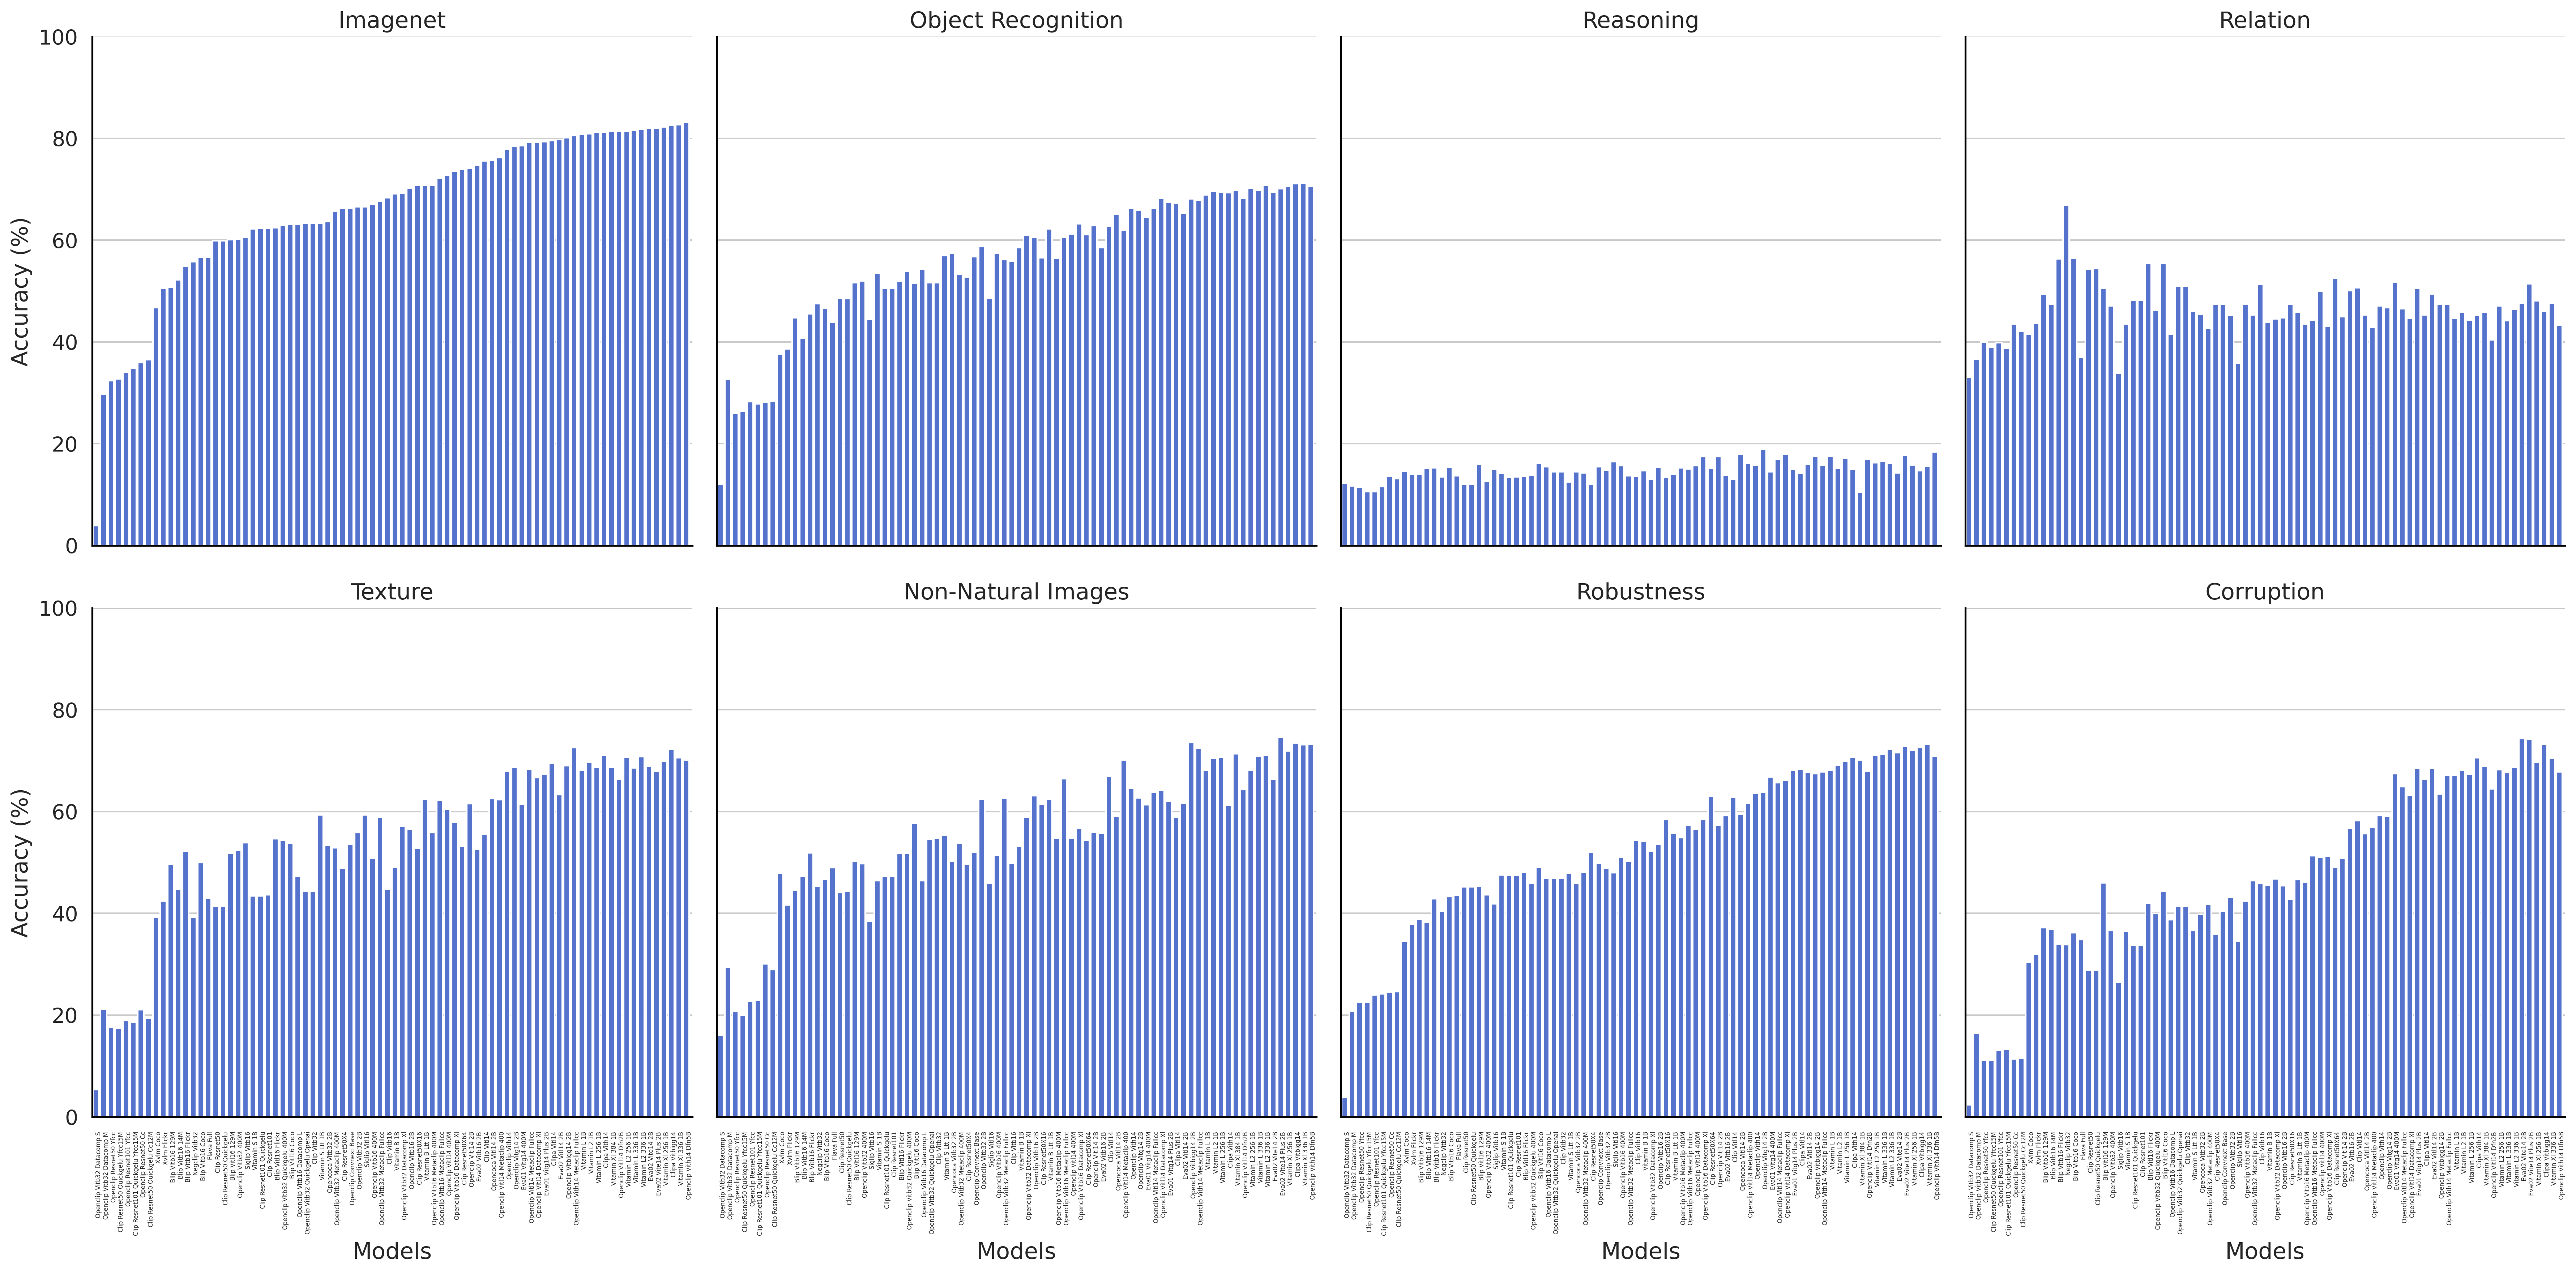

In [38]:
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24, 12), dpi=300)

df_imagenet = df_mean[df_mean.benchmark_name == "imagenet1k"]

order = list(df_imagenet.groupby("model_name").correctness.mean().sort_values().index)
# order.append("2 Layer MLP")
benchmark_types = list(results.benchmark_type.unique())
benchmark_types.insert(0, "ImageNet")

sns.set_style(
    "whitegrid",
    rc={"ytick.left": True, "axes.grid": True},
)

for benchmark_type, ax in zip(benchmark_types, axs.flatten()):
    if benchmark_type == "ImageNet":
        m = df_imagenet
        s = df_sem[df_mean.benchmark_name == "imagenet1k"]
    else:
        m = df_mean[df_mean.benchmark_type == benchmark_type].reset_index()
        s = df_sem[df_mean.benchmark_type == benchmark_type].reset_index()

    m = m.reset_index().groupby("model_name").correctness.mean() * 100
    s = s.reset_index().groupby("model_name").correctness.mean() * 100

    ax1 = sns.barplot(
        x=list(m.keys()),
        y=list(m.values),
        palette=[
            "royalblue" if "2 Layer MLP" not in x else "forestgreen"
            for x in list(m.keys())
        ],
        errorbar=None,
        order=order,
        ax=ax,
    )

    for _, s in ax1.spines.items():
        s.set_color("black")

    ax.set_ylim(0, 100)
    sns.despine(ax=ax)

    ax.set_xticks(
        [x + 0.1 for x in ax.get_xticks()],
        [x.replace("_", " ").title() for x in order],
        rotation=90,
        ha="right",
    )

    ax.set_title(benchmark_type.replace("_", " ").title())

    ax.tick_params(axis="x", which="major", labelsize=4)

    ax.set_xlabel("Models")
    ax.set_ylabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("results_summary.pdf", dpi=300, bbox_inches="tight")